In [1]:
from architecture01_cnn import *

In [2]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.xavier_normal_(m.weight.data)
    elif classname.find('BatchNorm') != -1:
        nn.init.xavier_normal_(m.weight.data)
        nn.init.constant_(m.bias.data, 0)

In [3]:
# Check if your system supports CUDA
use_cuda = torch.cuda.is_available()

# Setup GPU optimization if CUDA is supported
if use_cuda:
    computing_device = torch.device("cuda")
    extras = {"num_workers": 1, "pin_memory": True}
    print("CUDA is supported")
else: # Otherwise, train on the CPU
    computing_device = torch.device("cpu")
    extras = False
    print("CUDA NOT supported")

net = Nnet().to(computing_device)
net.apply(weights_init)

# Print the model
print(net)

#loss criteria are defined in the torch.nn package
criterion = nn.BCELoss()

#Instantiate the gradient descent optimizer - use Adam optimizer with default parameters
optimizer = optim.Adam(net.parameters(),lr = 0.001)

CUDA is supported
Nnet(
  (main): Sequential(
    (0): Conv2d(3, 25, kernel_size=(5, 5), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(25, 50, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(50, 75, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(75, 75, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=3675, out_features=1000, bias=True)
    (1): ReLU(inplace)
    (2): Linear(in_features=1000, out_features=201, bias=True)
  )
)


In [4]:
transform = transforms.Compose([transforms.Resize(256), transforms.CenterCrop(256), transforms.ToTensor()])
dataset = loader('train.csv','/datasets/cs154-fa19-public/',transform=transform)
batch_size = 64
validation_split = .2
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                sampler=valid_sampler)

In [6]:
import copy
# Track the loss across training
total_loss = []
total_accu = []

train_losses = []
train_accuracies = []

avg_minibatch_loss = []
avg_minibatch_accu = []
N = 50

all_models = []

valid_losses = []
valid_accuracies = []

#Helper function for calculating accuracy
def calculate_accu(outputs, labels, batch_size):
    num_correct = torch.sum(torch.max(outputs, dim = 1)[1] == labels).item()
    return num_correct / batch_size

for epoch in range(50):
    
    N_minibatch_loss = 0.0
    N_minibatch_accu = 0.0

    # Get the next minibatch of images, labels for training
    for minibatch_count, (images, labels) in enumerate(train_loader, 0):
        print("mini_batch", minibatch_count)
        # Zero out the stored gradient (buffer) from the previous iteration
        optimizer.zero_grad()
        # Put the minibatch data in CUDA Tensors and run on the GPU if supported
        images, labels = images.to(computing_device), labels.to(computing_device)
        # Perform the forward pass through the network and compute the loss
        outputs = net(images)
        
        one_hot = torch.zeros(labels.shape[0], 201)
        one_hot[torch.arange(labels.shape[0]), labels] = 1
        one_hot = one_hot.cuda()

        loss = criterion(outputs, one_hot)
        accu = calculate_accu(outputs, labels, batch_size)
        
        # Automagically compute the gradients and backpropagate the loss through the network
        loss.backward()

        # Update the weights
        optimizer.step()    
        # Add this iteration's loss to the total_loss
        total_loss.append(loss.item())
        total_accu.append(accu)
        
        N_minibatch_loss += loss.item()
        N_minibatch_accu += accu
        
        if minibatch_count % N == 49:
            #Print the loss averaged over the last N mini-batches
            N_minibatch_loss /= N
            N_minibatch_accu /= N
            
            print('Epoch %d, average minibatch %d loss: %.3f' % (epoch + 1, minibatch_count+1, N_minibatch_loss))
            print('Epoch %d, average minibatch %d accuracy: %.3f' % (epoch + 1, minibatch_count+1, N_minibatch_accu))
            # Add the averaged loss over N minibatches and reset the counter
            avg_minibatch_loss.append(N_minibatch_loss)
            avg_minibatch_accu.append(N_minibatch_accu)
            
            N_minibatch_loss = 0.0
            N_minibatch_accu = 0.0
    
    train_losses.append(np.average(total_loss))
    train_accuracies.append(np.average(total_accu))
    
    # TODO: Implement validation 
    with torch.no_grad():
        
        valid_loss = 0
        valid_accu = 0
        
        for minibatch_count, (images, labels) in enumerate(validation_loader, 0):
            
            #Apply current model to the data
            images, labels = images.to(computing_device), labels.to(computing_device)
            outputs = net(images)
            
            one_hot = torch.zeros(labels.shape[0], 201)
            one_hot[torch.arange(labels.shape[0]), labels] = 1
            one_hot = one_hot.cuda()

            valid_accu += calculate_accu(outputs, labels, batch_size)
            valid_loss += criterion(outputs, one_hot).item()
        
        avg_valid_accu = valid_accu/minibatch_count
        avg_valid_loss = valid_loss/minibatch_count
        
        print("Valid loss for validation set is ", avg_valid_loss, ".")
        print("Accuracy for validation set is", avg_valid_accu * 100, "%.")
        
        all_models.append(copy.deepcopy(net))
        
        
        if not valid_losses:
            # set the first network as the best model
            model = copy.deepcopy(net)
        elif avg_valid_loss > valid_losses[-1]:
            # Stop Training when validation loss goes up
            valid_losses.append(avg_valid_loss)
            valid_accuracies.append(avg_valid_accu)
            break
        elif avg_valid_loss < min(valid_losses):
            # Set the best model if the average valid loss is the lowest
            model = copy.deepcopy(net)
        
        valid_losses.append(avg_valid_loss)
        valid_accuracies.append(avg_valid_accu)

mini_batch 0
mini_batch 1
mini_batch 2
mini_batch 3
mini_batch 4
mini_batch 5
mini_batch 6
mini_batch 7
mini_batch 8
mini_batch 9
mini_batch 10
mini_batch 11
mini_batch 12
mini_batch 13
mini_batch 14
mini_batch 15
mini_batch 16
mini_batch 17
mini_batch 18
mini_batch 19
mini_batch 20
mini_batch 21
mini_batch 22
mini_batch 23
mini_batch 24
mini_batch 25
mini_batch 26
mini_batch 27
mini_batch 28
mini_batch 29
mini_batch 30
mini_batch 31
mini_batch 32
mini_batch 33
mini_batch 34
mini_batch 35
mini_batch 36
mini_batch 37
mini_batch 38
mini_batch 39
mini_batch 40
mini_batch 41
mini_batch 42
mini_batch 43
mini_batch 44
mini_batch 45
mini_batch 46
mini_batch 47
mini_batch 48
mini_batch 49
Epoch 1, average minibatch 50 loss: 0.029
Epoch 1, average minibatch 50 accuracy: 0.039
mini_batch 50
mini_batch 51
mini_batch 52
mini_batch 53
mini_batch 54
mini_batch 55
mini_batch 56
mini_batch 57
mini_batch 58
mini_batch 59
mini_batch 60
mini_batch 61
mini_batch 62
mini_batch 63
mini_batch 64
mini_batch 6

mini_batch 124
mini_batch 125
mini_batch 126
mini_batch 127
mini_batch 128
mini_batch 129
mini_batch 130
mini_batch 131
mini_batch 132
mini_batch 133
mini_batch 134
mini_batch 135
mini_batch 136
mini_batch 137
mini_batch 138
mini_batch 139
mini_batch 140
mini_batch 141
mini_batch 142
mini_batch 143
mini_batch 144
mini_batch 145
mini_batch 146
mini_batch 147
mini_batch 148
mini_batch 149
Epoch 2, average minibatch 150 loss: 0.022
Epoch 2, average minibatch 150 accuracy: 0.239
mini_batch 150
mini_batch 151
mini_batch 152
mini_batch 153
mini_batch 154
mini_batch 155
mini_batch 156
mini_batch 157
mini_batch 158
mini_batch 159
mini_batch 160
mini_batch 161
mini_batch 162
mini_batch 163
mini_batch 164
mini_batch 165
mini_batch 166
mini_batch 167
mini_batch 168
mini_batch 169
mini_batch 170
mini_batch 171
mini_batch 172
mini_batch 173
mini_batch 174
mini_batch 175
mini_batch 176
mini_batch 177
mini_batch 178
mini_batch 179
mini_batch 180
mini_batch 181
mini_batch 182
mini_batch 183
mini_batch

mini_batch 241
mini_batch 242
mini_batch 243
mini_batch 244
mini_batch 245
mini_batch 246
mini_batch 247
mini_batch 248
mini_batch 249
Epoch 3, average minibatch 250 loss: 0.016
Epoch 3, average minibatch 250 accuracy: 0.442
mini_batch 250
mini_batch 251
mini_batch 252
mini_batch 253
mini_batch 254
mini_batch 255
mini_batch 256
mini_batch 257
mini_batch 258
mini_batch 259
mini_batch 260
mini_batch 261
mini_batch 262
mini_batch 263
mini_batch 264
mini_batch 265
mini_batch 266
mini_batch 267
mini_batch 268
mini_batch 269
mini_batch 270
mini_batch 271
mini_batch 272
mini_batch 273
mini_batch 274
mini_batch 275
mini_batch 276
mini_batch 277
mini_batch 278
mini_batch 279
mini_batch 280
mini_batch 281
mini_batch 282
mini_batch 283
mini_batch 284
mini_batch 285
mini_batch 286
mini_batch 287
mini_batch 288
mini_batch 289
mini_batch 290
mini_batch 291
mini_batch 292
mini_batch 293
mini_batch 294
mini_batch 295
mini_batch 296
mini_batch 297
mini_batch 298
mini_batch 299
Epoch 3, average minibatc

mini_batch 352
mini_batch 353
mini_batch 354
mini_batch 355
mini_batch 356
mini_batch 357
mini_batch 358
mini_batch 359
mini_batch 360
mini_batch 361
mini_batch 362
mini_batch 363
mini_batch 364
mini_batch 365
mini_batch 366
mini_batch 367
mini_batch 368
mini_batch 369
mini_batch 370
mini_batch 371
mini_batch 372
mini_batch 373
mini_batch 374
mini_batch 375
Valid loss for validation set is  0.014731580091099586 .
Accuracy for validation set is 51.02486559139785 %.
mini_batch 0
mini_batch 1
mini_batch 2
mini_batch 3
mini_batch 4
mini_batch 5
mini_batch 6
mini_batch 7
mini_batch 8
mini_batch 9
mini_batch 10
mini_batch 11
mini_batch 12
mini_batch 13
mini_batch 14
mini_batch 15
mini_batch 16
mini_batch 17
mini_batch 18
mini_batch 19
mini_batch 20
mini_batch 21
mini_batch 22
mini_batch 23
mini_batch 24
mini_batch 25
mini_batch 26
mini_batch 27
mini_batch 28
mini_batch 29
mini_batch 30
mini_batch 31
mini_batch 32
mini_batch 33
mini_batch 34
mini_batch 35
mini_batch 36
mini_batch 37
mini_batc

mini_batch 99
Epoch 6, average minibatch 100 loss: 0.008
Epoch 6, average minibatch 100 accuracy: 0.755
mini_batch 100
mini_batch 101
mini_batch 102
mini_batch 103
mini_batch 104
mini_batch 105
mini_batch 106
mini_batch 107
mini_batch 108
mini_batch 109
mini_batch 110
mini_batch 111
mini_batch 112
mini_batch 113
mini_batch 114
mini_batch 115
mini_batch 116
mini_batch 117
mini_batch 118
mini_batch 119
mini_batch 120
mini_batch 121
mini_batch 122
mini_batch 123
mini_batch 124
mini_batch 125
mini_batch 126
mini_batch 127
mini_batch 128
mini_batch 129
mini_batch 130
mini_batch 131
mini_batch 132
mini_batch 133
mini_batch 134
mini_batch 135
mini_batch 136
mini_batch 137
mini_batch 138
mini_batch 139
mini_batch 140
mini_batch 141
mini_batch 142
mini_batch 143
mini_batch 144
mini_batch 145
mini_batch 146
mini_batch 147
mini_batch 148
mini_batch 149
Epoch 6, average minibatch 150 loss: 0.008
Epoch 6, average minibatch 150 accuracy: 0.735
mini_batch 150
mini_batch 151
mini_batch 152
mini_batch 

mini_batch 210
mini_batch 211
mini_batch 212
mini_batch 213
mini_batch 214
mini_batch 215
mini_batch 216
mini_batch 217
mini_batch 218
mini_batch 219
mini_batch 220
mini_batch 221
mini_batch 222
mini_batch 223
mini_batch 224
mini_batch 225
mini_batch 226
mini_batch 227
mini_batch 228
mini_batch 229
mini_batch 230
mini_batch 231
mini_batch 232
mini_batch 233
mini_batch 234
mini_batch 235
mini_batch 236
mini_batch 237
mini_batch 238
mini_batch 239
mini_batch 240
mini_batch 241
mini_batch 242
mini_batch 243
mini_batch 244
mini_batch 245
mini_batch 246
mini_batch 247
mini_batch 248
mini_batch 249
Epoch 7, average minibatch 250 loss: 0.007
Epoch 7, average minibatch 250 accuracy: 0.815
mini_batch 250
mini_batch 251
mini_batch 252
mini_batch 253
mini_batch 254
mini_batch 255
mini_batch 256
mini_batch 257
mini_batch 258
mini_batch 259
mini_batch 260
mini_batch 261
mini_batch 262
mini_batch 263
mini_batch 264
mini_batch 265
mini_batch 266
mini_batch 267
mini_batch 268
mini_batch 269
mini_batch

# Apply Model On the Test Dataset

In [9]:
#Create test set
test_dataset = loader('test.csv','/datasets/cs154-fa19-public/',
                      transform = transform)

test_loader = torch.utils.data.DataLoader(test_dataset, 
                                          batch_size = batch_size)

## Test Set Preformance

In [13]:
#helper functions

#model for performance
def per_class_model_performance(performances):
    
    perf_df = []
    
    #for each class, calculate accuracy, recall, precision and bcr
    for i in range(len(performances)):
        
        cur_perf = performances[i]
        accu, recall, precision, bcr = get_per_class_values(cur_perf)
        
        perf_df.append([accu, precision, recall, bcr])
        
    #make it to a dataframe
    perf_df = pd.DataFrame(perf_df)
    perf_df.columns = ['Accuracy', 'Precision', 'Recall', 'BCR']
    
    return perf_df
 

#get measurement recall, accuracy, precision and bcr value for the current class
def get_per_class_values(cur_perf):    
    
    tp = cur_perf['TP']
    fp = cur_perf['FP']
    tn = cur_perf['TN']
    fn = cur_perf['FN']
    
    #accuracy
    accu = (tp + tn)/(tp + tn + fp + fn)
    
    #recall
    if tp + fn == 0:
        recall = 0
    else:
        recall = tp / (tp + fn)
    
    #precision
    if fp + tp == 0:
        precision = 0
    else:
        precision = tp / (fp + tp)
        
    #bcr
    bcr = (precision + recall) / 2
    
    return accu, recall, precision, bcr

In [11]:
#Apply to test set and test Performances
all_class_performance = []

#turn list into a sparse matrix
def make_matrix(lst):
    mat = []
    for i in lst:
        cur = [0] * 201
        cur[i] = 1
        mat.append(cur)
    return np.array(mat)


for i in range(201):
    all_class_performance.append({'TP': 0, 'FP': 0, 'TN': 0, 'FN': 0})

with torch.no_grad(): 
    
    test_accu = 0
    
    for minibatch_count, (images, labels) in enumerate(test_loader, 0):
        
        print("current minibatch: ", minibatch_count)
        # Put the minibatch data in CUDA Tensors and run on the GPU if supported
        images, labels = images.to(computing_device), labels.to(computing_device) 
        outputs = model(images)
        
        test_accu += calculate_accu(outputs, labels, batch_size)
        
        predictions = torch.max(outputs, dim = 1)[1]

        pred = make_matrix(predictions.tolist())
        lab = make_matrix(labels.tolist())

        for i in range(pred.shape[0]):
            for j in range(201):
                if (pred[i][j] == 1) and (lab[i][j] == 1):
                    all_class_performance[j]['TP'] += 1
                elif (pred[i][j] == 1) and (lab[i][j] == 0):
                    all_class_performance[j]['FP'] += 1
                elif (pred[i][j] == 0) and (lab[i][j] == 0):
                    all_class_performance[j]['TN'] += 1
                else:
                    all_class_performance[j]['FN'] += 1
                    
    test_accuracy = (test_accu/minibatch_count)

current minibatch:  0
current minibatch:  1
current minibatch:  2
current minibatch:  3
current minibatch:  4
current minibatch:  5
current minibatch:  6
current minibatch:  7
current minibatch:  8
current minibatch:  9
current minibatch:  10
current minibatch:  11
current minibatch:  12
current minibatch:  13
current minibatch:  14
current minibatch:  15
current minibatch:  16
current minibatch:  17
current minibatch:  18
current minibatch:  19
current minibatch:  20
current minibatch:  21
current minibatch:  22
current minibatch:  23
current minibatch:  24
current minibatch:  25
current minibatch:  26
current minibatch:  27
current minibatch:  28
current minibatch:  29
current minibatch:  30
current minibatch:  31
current minibatch:  32
current minibatch:  33
current minibatch:  34
current minibatch:  35
current minibatch:  36
current minibatch:  37
current minibatch:  38
current minibatch:  39
current minibatch:  40
current minibatch:  41
current minibatch:  42
current minibatch:  4

In [12]:
print('The test accuracy for the best model trained above is ' + str(test_accuracy * 100) + '%.')

The test accuracy for the best model trained above is 60.25%.


In [14]:
perf_df = per_class_model_performance(all_class_performance)

In [21]:
#Bottom five
perf_df.sort_values(by = 'Accuracy')[:5]

,Accuracy,Precision,Recall,BCR
37,0.979295,0.206349,0.433333,0.319841
1,0.985785,0.340909,0.468750,0.404830
93,0.986094,0.318182,0.482759,0.400470
21,0.987330,0.321429,0.290323,0.305876
65,0.989493,0.305556,0.550000,0.427778


In [22]:
#Top five
perf_df.sort_values(by = 'Accuracy', ascending=False)[1:6]

,Accuracy,Precision,Recall,BCR
47,1.000000,1.000000,1.000000,1.000000
133,0.999691,1.000000,0.875000,0.937500
73,0.999382,0.857143,0.857143,0.857143
44,0.999382,1.000000,0.777778,0.888889
196,0.999382,0.875000,0.875000,0.875000


## Visualizations

In [23]:
import matplotlib.pyplot as plt

### Training and Validation Loss Curves

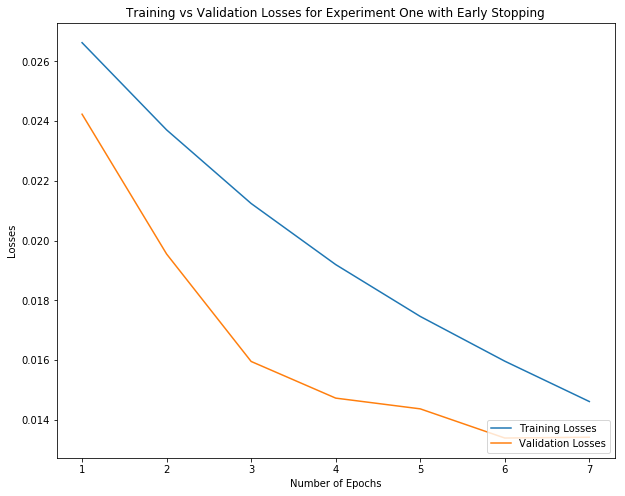

In [24]:
graph_title = 'Training vs Validation Losses for Experiment One with Early Stopping'

fig = plt.figure(figsize=(10, 8))
ax = plt.subplot()
ax.plot(np.arange(1, len(train_losses) + 1), train_losses, label='Training Losses')
ax.plot(np.arange(1, len(valid_losses) + 1), valid_losses, label='Validation Losses')
ax.set(xlabel='Number of Epochs', ylabel='Losses',
           title=graph_title)
leg = ax.legend(loc=4)
fig.savefig('experiment1_train_vad_loss.png')

### Plot on Training and Testing Accuracy Curves

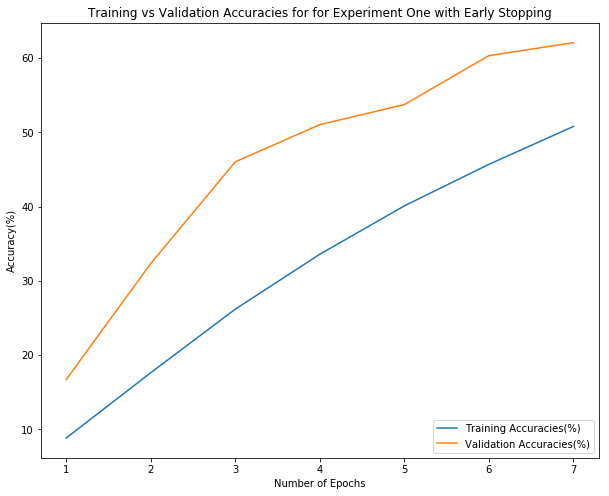

In [25]:
graph_title = 'Training vs Validation Accuracies for for Experiment One with Early Stopping'

fig = plt.figure(figsize=(10, 8))
ax = plt.subplot()
ax.plot(np.arange(1, len(train_accuracies) + 1), np.array(train_accuracies) * 100, label='Training Accuracies(%)')
ax.plot(np.arange(1, len(valid_accuracies) + 1), np.array(valid_accuracies) * 100, label='Validation Accuracies(%)')
ax.set(xlabel='Number of Epochs', ylabel='Accuracy(%)',
           title=graph_title)
leg = ax.legend(loc=4)
fig.savefig('experiment1_train_test_accu.png')

### Filter Maps

In [26]:
for idx, m in enumerate(model.modules()):
    print(idx, '->', m)

0 -> Nnet(
  (main): Sequential(
    (0): Conv2d(3, 25, kernel_size=(5, 5), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(25, 50, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(50, 75, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(75, 75, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=3675, out_features=1000, bias=True)
    (1): ReLU(inplace)
    (2): Linear(in_features=1000, out_features=201, bias=True)
  )
)
1 -> Sequential(
  (0): Conv2d(3, 25, kernel_size=(5, 5), stride=(4, 4), padding=(2, 2))
  (1): ReLU(inplace)
  (2): MaxPool2d(kernel_size=3, s

In [28]:
filter_imgs = []
# Get the weights for each needed filter
for idx, m in enumerate(model.modules()):
    if idx == 2:     
        #early filters
        early = (m.weight.cpu().data.numpy()[1])[0]  
        early2 = (m.weight.cpu().data.numpy()[4])[0]
        filter_imgs.append(early)
        filter_imgs.append(early2)
        
    if idx == 8:
        # middle filters
        middle = (m.weight.cpu().data.numpy()[1])[0]
        middle2 = (m.weight.cpu().data.numpy()[4])[0]
        filter_imgs.append(middle)
        filter_imgs.append(middle2)
    
    if idx == 10:
        # late filters
        late = (m.weight.cpu().data.numpy()[1])[0]
        late2 = (m.weight.cpu().data.numpy()[4])[0]
        filter_imgs.append(late)
        filter_imgs.append(late2)
        break 

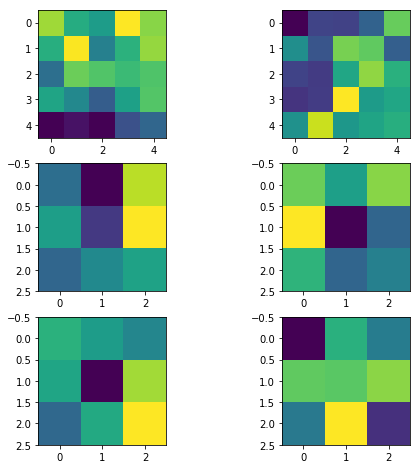

In [30]:
fig = plt.figure(figsize=(8, 8))
cols = 2
rows = 3

for i in range(1, cols * rows + 1):
    img = filter_imgs[i-1]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img)
    
plt.savefig('experiment1_filter.png')